last modification 11:00


In [67]:
import pandas
import keras
import matplotlib
import tensorflow
import numpy
import time
import itertools

from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv1D, Dense
from google.colab import drive

In [68]:
drive.mount('/content/drive')

device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  
print('Found GPU at: {}'.format(device_name))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found GPU at: /device:GPU:0


In [70]:
def plot_loss(history):
  """
  Utility function used to plot 'loss' function trend. It is used to show that, after one point, the loss stops decreasing.
  """

  loss = history.history["loss"]
    
  epochs = range(len(loss))
    
  matplotlib.pyplot.figure()
  matplotlib.pyplot.plot(epochs, loss, "b", label="Training loss")
  #matplotlib.pyplot.plot(epochs, val_loss, "r", label="Validation loss")
  #matplotlib.pyplot.title(self._name)
  matplotlib.pyplot.xlabel("Epochs")
  matplotlib.pyplot.ylabel("Loss")
  matplotlib.pyplot.legend()
  matplotlib.pyplot.show()

def plot_raw_data(data, title, index_column_name, data_column_names, x_label="", y_label=""):
  """
  Utility function used to plot raw data.
  """
  
  matplotlib.pyplot.rcParams['figure.figsize'] = [20, 10]
  matplotlib.pyplot.rcParams['figure.dpi'] = 70
    
  plot_data = data[data_column_names]
  plot_data.index = data[index_column_name]
  plot_data.head()
  plot_data.plot(rot=25, title=title)

  matplotlib.pyplot.xlabel(x_label)
  matplotlib.pyplot.ylabel(y_label)
  matplotlib.pyplot.show()

def plot_prediction_results(appliance_name, real_data, predicted_data):
  """
  Utility function used to plot prediction results compared to real data.
  """

  figure, axes = matplotlib.pyplot.subplots()
    
  axes.plot(real_data, label='real_data')
  axes.plot(predicted_data, label='predicted_data')
  axes.legend(loc='upper center', shadow=True)

  matplotlib.pyplot.show()

def column_matrix_to_array(input):
  """
  Utility function used to convert a column matrix into an array.
  """
  output = []
  for row_index in range (0, len(input)):
    output.append(input[row_index,0])
  return output

def compute_f1_score(predicted_values, real_values):
  """
  Utility function used to compute the 'energy based F1 score' according to project specifications.
  """

  if len(predicted_values) != len(real_values):
    raise ValueError("ERROR: 'predicted_values' and 'real_values' have different size!")

  if len(predicted_values) == 0:
    raise ValueError("ERROR: 'predicted_values' and 'real_values' are empty!")

  if not isinstance(predicted_values, list) or not isinstance(real_values, list):
    raise ValueError("ERROR: Only 'list' type are accepted!")

  numerator = 0.0

  for x in range(0, len(predicted_values)):
    numerator += min(predicted_values[x], real_values[x])
  
  numerator_p = numerator
  denominator_p = sum(predicted_values)

  numerator_r = numerator
  denominator_r = sum(real_values)

  p = numerator_p / denominator_p
  r = numerator_r / denominator_r

  return 2 * ((p * r) / (p + r))

# Raw Data Import and Visualization

Time used for raw data import: 32.22626280784607


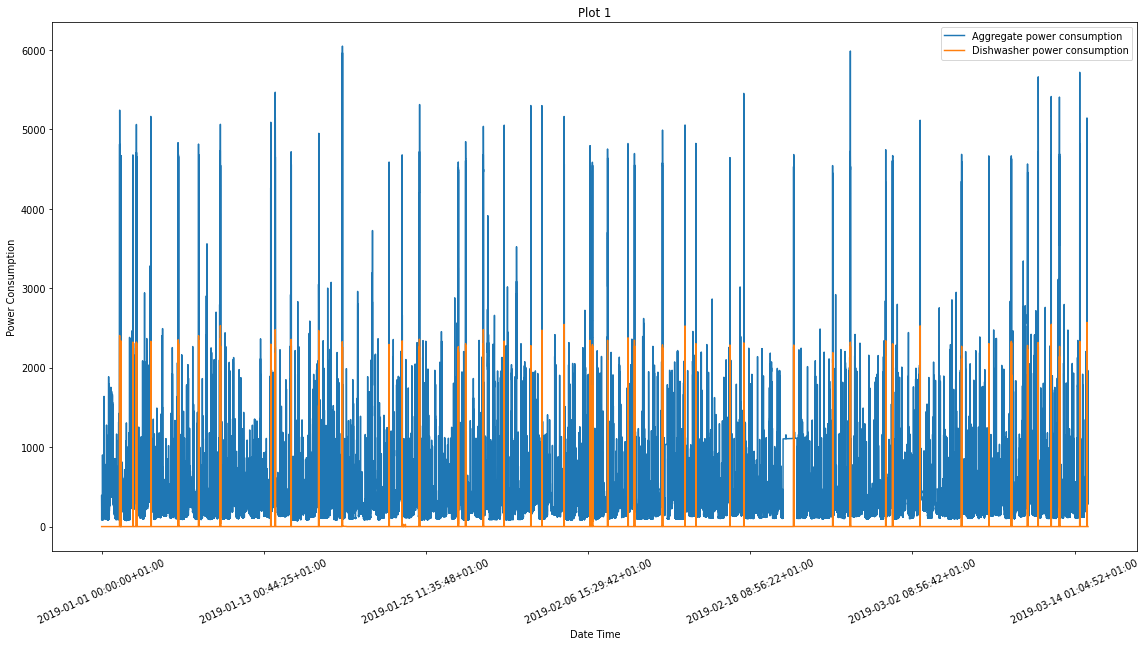

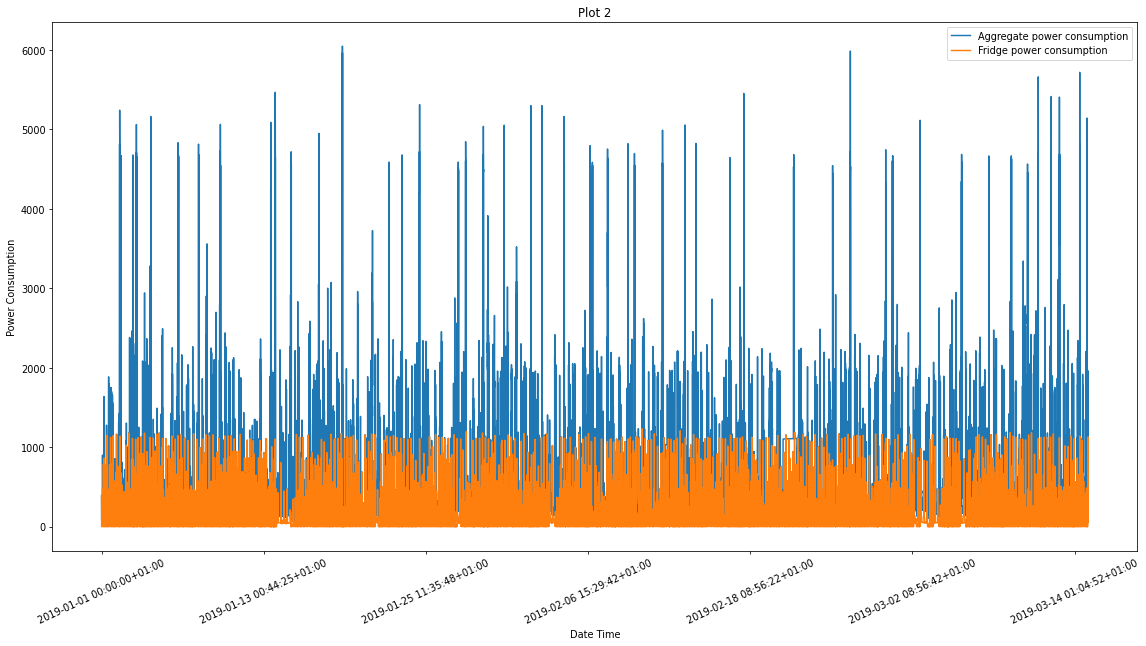

In [71]:
# Import raw data...

start = time.time()

raw_data = pandas.DataFrame(columns=['Date Time']) 

raw_data_from_csv = pandas.read_csv('/content/drive/My Drive/main_train.csv', names=['Date Time','Aggregate power consumption'], header=0) 
raw_data = raw_data.merge(raw_data_from_csv, how='outer')

raw_data_from_csv = pandas.read_csv('/content/drive/My Drive/dishwasher_train.csv', names=['Date Time','Dishwasher power consumption'], header=0) 
raw_data = raw_data.merge(raw_data_from_csv, how='outer')

raw_data_from_csv = pandas.read_csv('/content/drive/My Drive/fridge_train.csv', names=['Date Time','Fridge power consumption'], header=0) 
raw_data = raw_data.merge(raw_data_from_csv, how='outer')

print('Time used for raw data import: {}'.format(time.time() - start))

# Plot data...
plot_raw_data(raw_data, "Plot 1", 'Date Time', ['Aggregate power consumption', 'Dishwasher power consumption'], "Date Time", "Power Consumption")
plot_raw_data(raw_data, "Plot 2", 'Date Time', ['Aggregate power consumption', 'Fridge power consumption'], "Date Time", "Power Consumption")



In [72]:
raw_data

,Date Time,Aggregate power consumption,Dishwasher power consumption,Fridge power consumption
0,2019-01-01 00:00:00+01:00,96.303,0.0,2.5
1,2019-01-01 00:00:01+01:00,96.303,0.0,2.5
2,2019-01-01 00:00:02+01:00,96.303,0.0,2.5
3,2019-01-01 00:00:03+01:00,96.303,0.0,2.5
4,2019-01-01 00:00:04+01:00,96.303,0.0,2.5
...,...,...,...,...
6082503,2019-03-14 23:59:55+01:00,351.493,0.0,135.6
6082504,2019-03-14 23:59:56+01:00,351.493,0.0,135.6
6082505,2019-03-14 23:59:57+01:00,351.493,0.0,135.6
6082506,2019-03-14 23:59:58+01:00,351.493,0.0,135.6


# Raw Data Preprocessing


In [73]:
class DataPreprocessor(object):
  """
  This class is used to easly preprocess data.
  """

  def __init__(self, data, train_split):

    self._data = data
    
    self._data_mean = data.mean()
    self._data_std = data.std() 
    self._data_min = data.min()
    self._data_max = data.max()

  def get_standardized_data(self):
    return (self._data - self._data_mean) / self._data_std

  def get_normalized_data(self):
    return (self._data - self._data_min) / (self._data_max - self._data_min)

  def destandardize_data(self, input):
    return (input * self._data_std) + self._data_mean

  def denormalize_data(self, input):
    return (input * (self._data_max - self._data_min)) + self._data_min

# Dishwasher's neural network training


In [74]:
class AbstractNeuralNetwork(object):
  """
  This class is used to represent a generic neural newtork.
  It is intended to perform hyperparameter optimization.
  """

  def __init__(self):
    
    self._hyperparameters = []
    self._generate_all_possible_hyperparameters_combinations()
    

  def _generate_all_possible_hyperparameters_combinations(self):
    """
    This method is used to generate all possible hyperparameters combinations
    """

    hyperparameters_list = [
      [16, 32, 64],       # Number of filters
      [4, 8, 16],         # Kernel sizes
      [256, 512, 1024]    # Number of units of 'Dense' layer                 
    ]    

    for element in itertools.product(*hyperparameters_list):
      self._hyperparameters.append(element) 

class DishwasherNeuralNetwork(AbstractNeuralNetwork):
  """
  This class is used to represent the neural newtork of the 'dishwasher' appliance.
  """
  
  def __init__(self):
    
    super().__init__()

    self._best_model_filepath='dishwasher_model_checkpoint.h5'
    self._current_hyperparameter_combiantion_index = -1
    self._history = None
    self._model = None

    # Following callback is required in order to save the best model observed during training 
    self._model_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=5)   
    self._model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
      monitor="loss",
      filepath=self._best_model_filepath,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
    )


  def build(self, debug=True):
    
    # Update current hyperparameters combination index
    self._current_hyperparameter_combiantion_index += 1   

    # Current hyperparameters combination
    h = self._hyperparameters[self._current_hyperparameter_combiantion_index]   

    if debug:
      print('Number of filters                  : {}'.format(h[0]))
      print('Kernel sizes                       : {}'.format(h[1]))
      print('Number of units of Dense layer     : {}'.format(h[2]))
     

    # Built neural network with current hyperparameters combination
    self._model = Sequential()
    self._model.add(Conv1D(filters=h[0], kernel_size=h[1], strides=1, activation="relu", padding='same', input_shape=(1, 1)))
    self._model.add(Conv1D(filters=h[0], kernel_size=h[1], strides=1, activation="relu", padding='same'))
    self._model.add(Conv1D(filters=h[0], kernel_size=h[1], strides=1, activation="relu", padding='same'))
    self._model.add(Conv1D(filters=h[0], kernel_size=h[1], strides=1, activation="relu", padding='same'))
    self._model.add(Conv1D(filters=h[0], kernel_size=h[1], strides=1, activation="relu", padding='same'))

    self._model.add(Dense(h[2], activation='relu'))
    self._model.add(Dense(1, activation='linear'))

    self._model.compile(optimizer='adam', loss='mae')
    self._model.summary()

  def train(self, train_input, train_output): 
    self._history = self._model.fit(train_input, train_output, epochs=1, batch_size=256, callbacks=[self._model_callback, self._model_checkpoint_callback],)

  def predict(self, input): 

    # Load best model...
    self._model.load_weights(self._best_model_filepath)

    # Make predictions...
    return self._model.predict(input)



In [75]:
class SlidingWindowWalkForward(object):

    def __init__(self, dataset_size):
        """
        Implementation of 'Sliding Windows' version of 'Walk Forward' validation technique.
        In this way, our model will be trained only on the most recent observations.
        """

        # Parameter used to represent the number of observations to ignore.
        self._ignore_observations_up_to = 0

        # Testing set's number of observations is the same as stated by in project's specifications: 16 days of data!
        self._testing_set_size = 60 * 60 * 24 * 16

        # Training set's number of observations is 2.39 higher than that of testing set.
        self._training_set_size = (dataset_size - 2 * self._testing_set_size)

        # Sliding windows step
        self._sliding_window_step = self._testing_set_size

        # Iteration index
        self._iteration_index = 0

    def get_next_iteration_indexes(self, debug=True):
        
        training_set_first_observation = self._ignore_observations_up_to
        training_set_last_observation = training_set_first_observation + self._training_set_size

        test_set_first_observation = training_set_last_observation
        test_set_last_observation = training_set_last_observation + self._testing_set_size

        if debug:
            print('Current iteration   : {}'.format(self._iteration_index))
            print('Training set        : [{}:{}]'.format(training_set_first_observation, training_set_last_observation))
            print('Testing set         : [{}:{}]'.format(test_set_first_observation, test_set_last_observation))
            print('Ignored observations: {}\n'.format(self._ignore_observations_up_to))

        self._ignore_observations_up_to += self._sliding_window_step
        self._iteration_index += 1

        return training_set_first_observation, training_set_last_observation, test_set_first_observation, test_set_last_observation


Number of filters                  : 16
Kernel sizes                       : 4
Number of units of Dense layer     : 256
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_125 (Conv1D)          (None, 1, 16)             80        
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 1, 16)             1040      
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 1, 16)             1040      
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 1, 16)             1040      
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 1, 16)             1040      
_________________________________________________________________
dense_50 (Dense)             (None, 1, 256)            4352      

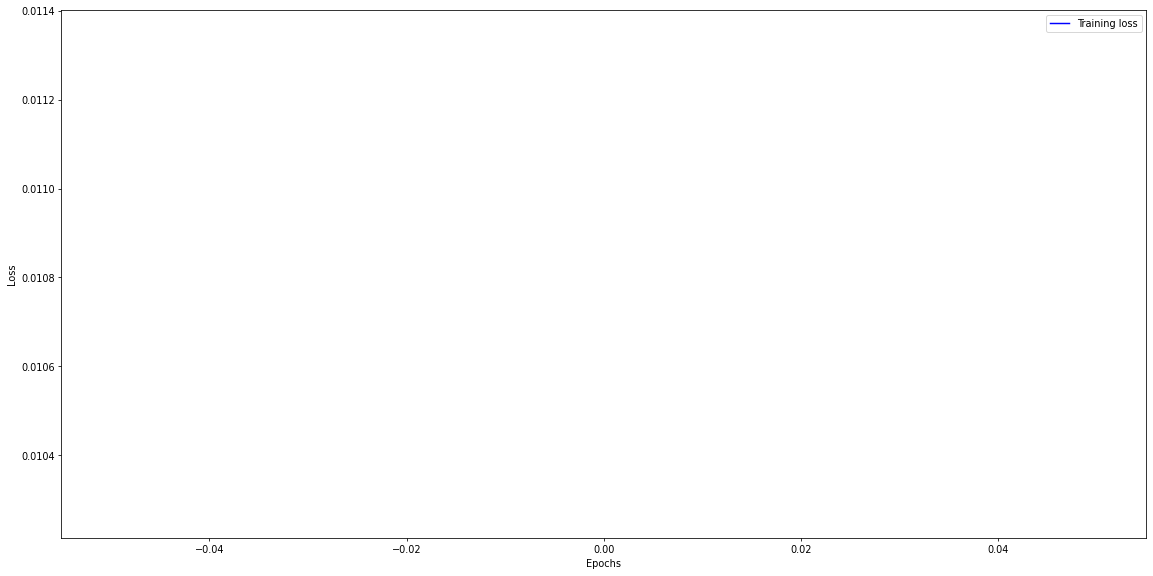

-0.19250106811523438
0.0


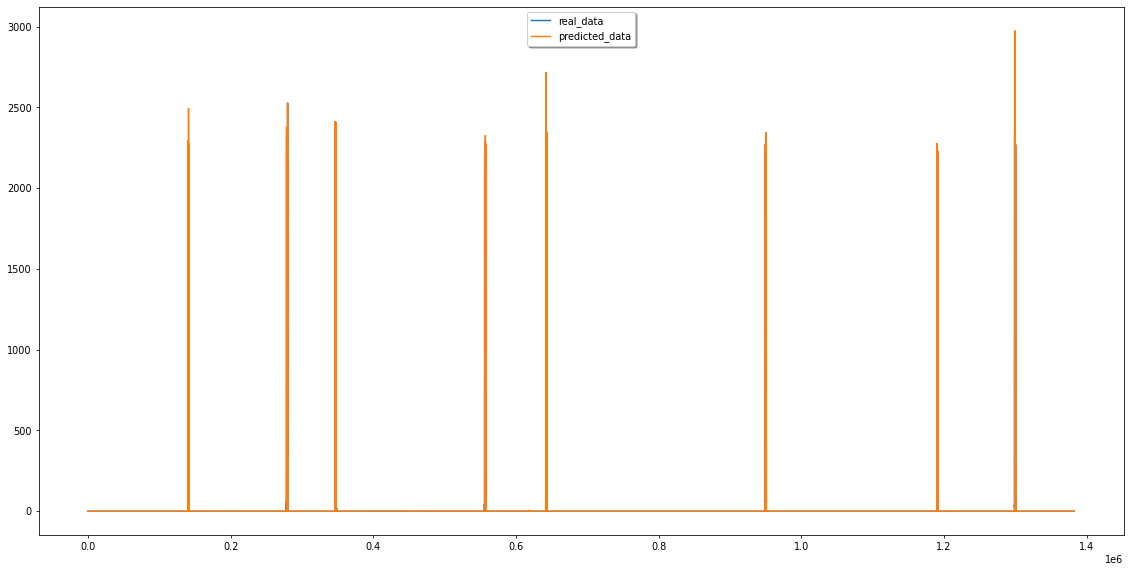

Computed Energy Based F1 Score: 0.9733050200836052


In [77]:



validation_technique = SlidingWindowWalkForward(len(raw_data))

appliance_name = 'Dishwasher'
appliance_column_name = 'Dishwasher power consumption'
appliance_naural_network = DishwasherNeuralNetwork()
appliance_naural_network.build(debug=True)

while(True):

  train_1, train_2, test_1, test_2 = validation_technique.get_next_iteration_indexes(debug=True)

  # Build data series...
  aggregate_data_series = raw_data['Aggregate power consumption']
  aggregate_data_series.index = raw_data['Date Time']
  
  appliance_data_series = raw_data[appliance_column_name]
  appliance_data_series.index = raw_data['Date Time']

  # Build data 'DataPreprocessors' objects...
  aggregate_data_preprocessor = DataPreprocessor(aggregate_data_series.values, train_2 - train_1)
  appliance_data_preprocessor = DataPreprocessor(appliance_data_series.values, train_2 - train_1)

  # Preprocess data...
  aggregate_data_series_preprocessed = pandas.DataFrame(aggregate_data_preprocessor.get_standardized_data())
  appliance_data_series_preprocessed = pandas.DataFrame(appliance_data_preprocessor.get_standardized_data())

  # Build training set...
  train_values = aggregate_data_series_preprocessed.values[train_1:train_2]
  train_label = appliance_data_series_preprocessed.values[train_1:train_2]

  # Build test set (if available)...
  test_values = aggregate_data_series_preprocessed.values[test_1:test_2]
  test_label = appliance_data_series_preprocessed.values[test_1:test_2]

  # Reshaping....
  train_values = train_values.reshape(train_values.shape[0], train_values.shape[1], 1)
  train_label = train_label.reshape(train_label.shape[0], train_label.shape[1], 1)
  test_values = test_values.reshape(test_values.shape[0], test_values.shape[1], 1)

  # Training
  appliance_naural_network.train(train_values, train_label)

  # Make some predictions...
  predicted_output = appliance_naural_network.predict(test_values)
  plot_loss(appliance_naural_network._history)

  # Reshaping....
  predicted_output = predicted_output.reshape(predicted_output.shape[0],)
  test_label = test_label.reshape(test_label.shape[0],)

  # De-Preprocess data...
  x = appliance_data_preprocessor.destandardize_data(predicted_output).tolist()
  y = appliance_data_preprocessor.destandardize_data(test_label).tolist()

  print(x[0])
  print(y[0])

  plot_prediction_results(appliance_name, y, x)  
  print("Computed Energy Based F1 Score: {}".format(compute_f1_score(x,y)))

  break

# Neural Networks architectures

In [ ]:
class FridgeNeuralNetwork(object):
    """
    This class implements the neural network for 'Fridge' appliance
    """
    def __init__(self):
        
        self._model = Sequential()

        self._model.add(Conv1D(filters=30, kernel_size=10, strides=1, activation="relu", padding='same', input_shape=(1, 1)))

        #output.add(Conv1D(filters=30, kernel_size=8, strides=1, activation="relu", padding='same'))
        #output.add(Conv1D(filters=40, kernel_size=6, strides=1, activation="relu", padding='same'))
        #output.add(Conv1D(filters=50, kernel_size=5, strides=1, activation="relu", padding='same'))
        #output.add(Conv1D(filters=50, kernel_size=5, strides=1, activation="relu", padding='same'))
        #output.add(Conv1D(filters=50, kernel_size=5, strides=1, activation="relu", padding='same'))

        self._model.add(Dense(1024, activation='relu'))
        self._model.add(Dense(1, activation='sigmoid'))

        self._model.compile(optimizer='adam', loss='mae')
        self._model.summary()

    def fit(self, data, labels):
        self._model.fit(data, labels, epochs=1)

    def predict(self, data):
        output = []

        prediction_from_regression = self._model.predict(data)

        for index in range(0, prediction_from_regression.shape[0]):
            output.append(prediction_from_regression[index][0][0])

        return output
        

In [ ]:
def show_results(appliance_name, real_data, predicted_data):
    
    figure, axes = matplotlib.pyplot.subplots()
    
    axes.plot(real_data, label='real_data')
    axes.plot(predicted_data, label='predicted_data')
    axes.legend(loc='upper center', shadow=True)

    matplotlib.pyplot.show()

  
   

    #accuracy_metrics = AccuracyMetrics(real_data, predicted_data)
    #f1_score = accuracy_metrics.get_f1()

    #print('Appliance name: {} --> F1 score: {}'.format(appliance_name, f1_score))

In [ ]:
def perform_training(dataset_registry, appliance_name, appliance_neural_network):
    
    appliance_dataset = dataset_registry.get(appliance_name)
    aggregate_dataset = dataset_registry.get('Aggregate')

    dataset_size = appliance_dataset.size
    sliding_window_walk_forward = SlidingWindowWalkForward(dataset_size)

    appliance_dataset_values = appliance_dataset.values
    aggregate_dataset_values = aggregate_dataset.values

    while True:

        # 'x1' represents the first observation which belongs to training set
        # 'x2' represents the last observation which belongs to training set
        # 'y1' represents the first observation which belongs to testing set
        # 'y1' represents the last observation which belongs to testing set

        x1, x2, y1, y2 = sliding_window_walk_forward.get_next_iteration_indexes(debug=True)
        x1 = 0
        x2 = 4000
        x2 = 4000
        x2 = 6000


        data = get_values_range(aggregate_dataset_values, x1, x2, feature_scaling='standardization')
        labels = get_values_range(appliance_dataset_values, x1, x2, feature_scaling='standardization')

        #Common.show_shape(data, labels)

        appliance_neural_network.fit(data, labels)

        if y2 == dataset_size:
            break

        data_for_prediction = get_values_range(aggregate_dataset_values, y1, y2, feature_scaling='standardization')
        real_data = get_values_range(appliance_dataset_values, y1, y2, feature_scaling='standardization')

        predicted_data = appliance_neural_network.predict(data_for_prediction)

        x = []
        for value in real_data:
            x.append(value[0])
        real_data = x

        show_results(appliance_name, real_data, predicted_data)
        exit(75)
